# Test significance of S1, S2, D1, D2
The idea is to follow the procedure of the paper "Assessing harmfulness and vulnerability in global bipartite networks of
terrorist-target relationships" A. Spelta et al.

In [1]:
import sys

sys.path.insert(0, "../")

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scripts.hid_haus import hid_hous
from scripts.get_graph import get_graph
from scripts.z_score import *

## Get Adjacency matrix and graph

In [2]:
# Get the adjacency matrix from the data
adjacency_matrix = pd.read_csv("../../dataset/large_adjacency_matrix.csv", compression='gzip').values

graph = get_graph(adjacency_matrix)

## Null Model Construction (Level-1)


In [9]:
# Create an ensemble of random networks
num_null_models = 700
null_models = [generate_null_model(graph) for _ in range(num_null_models)]

In [10]:
top_nodes, bottom_nodes = nx.bipartite.sets(graph)

top_degrees = graph.degree(top_nodes)
top_degrees = [degree for _, degree in top_degrees]

bottom_degrees = graph.degree(bottom_nodes)
bottom_degrees = [degree for _, degree in bottom_degrees]

config_model = nx.bipartite.configuration_model(top_degrees, bottom_degrees)
config_model.nodes.data()

NodeDataView({0: {'bipartite': 0}, 1: {'bipartite': 0}, 2: {'bipartite': 0}, 3: {'bipartite': 0}, 4: {'bipartite': 0}, 5: {'bipartite': 0}, 6: {'bipartite': 0}, 7: {'bipartite': 0}, 8: {'bipartite': 0}, 9: {'bipartite': 0}, 10: {'bipartite': 0}, 11: {'bipartite': 0}, 12: {'bipartite': 0}, 13: {'bipartite': 0}, 14: {'bipartite': 0}, 15: {'bipartite': 0}, 16: {'bipartite': 0}, 17: {'bipartite': 0}, 18: {'bipartite': 0}, 19: {'bipartite': 0}, 20: {'bipartite': 0}, 21: {'bipartite': 0}, 22: {'bipartite': 0}, 23: {'bipartite': 0}, 24: {'bipartite': 0}, 25: {'bipartite': 0}, 26: {'bipartite': 0}, 27: {'bipartite': 0}, 28: {'bipartite': 0}, 29: {'bipartite': 0}, 30: {'bipartite': 0}, 31: {'bipartite': 0}, 32: {'bipartite': 0}, 33: {'bipartite': 0}, 34: {'bipartite': 0}, 35: {'bipartite': 0}, 36: {'bipartite': 0}, 37: {'bipartite': 0}, 38: {'bipartite': 0}, 39: {'bipartite': 0}, 40: {'bipartite': 0}, 41: {'bipartite': 0}, 42: {'bipartite': 0}, 43: {'bipartite': 0}, 44: {'bipartite': 0}, 45: {'

## Statistical Validation:


### Compute the Z-score

In [11]:
null_model_measures_kd = []
null_model_measures_ks = []

for null_model in null_models:
    top_nodes, bottom_nodes = nx.bipartite.sets(null_model)
    adjacency_matrix = nx.bipartite.biadjacency_matrix(
        null_model, row_order=top_nodes, column_order=bottom_nodes
    )
    k_d, k_s = hid_hous(adjacency_matrix, 2)

    null_model_measures_kd.append(k_d)
    null_model_measures_ks.append(k_s)

null_model_measures_kd = np.array(null_model_measures_kd)
null_model_measures_ks = np.array(null_model_measures_ks)

real_k_d, real_k_s = hid_hous(adjacency_matrix, 2)

# Compute Z-scores
z_score_kd = calculate_z_score(real_k_d, null_model_measures_kd)
z_score_ks = calculate_z_score(real_k_s, null_model_measures_ks)

### Create a dataframe containing all metrics

In [12]:
disease_df = pd.read_csv("../../dataset/diseases.csv")

disease_df["L1 Z-score"] = z_score_kd[:, 0].tolist()
disease_df["L2 Z-score"] = z_score_kd[:, 1].tolist()


symptoms_df = pd.read_csv("../../dataset/symptoms.csv")
symptoms_df = symptoms_df[symptoms_df["symptom"] != "Disease"]
print("df length", len(symptoms_df))
print("z_score length", len(z_score_ks))
symptoms_df["L1 Z-score"] = z_score_ks[:, 0].tolist()
symptoms_df["L2 Z-score"] = z_score_ks[:, 1].tolist()

df length 325
z_score length 325


### Store the dataframes

In [13]:
symptoms_df.to_csv("../../dataset/symptoms_z_score.csv", compression="gzip")
disease_df.to_csv("../../dataset/diseases_z_score.csv", compression="gzip")

## Visualize the z-score

### Load data

In [14]:
symptoms_df = pd.read_csv("../../dataset/symptoms_z_score.csv", compression="gzip")
disease_df = pd.read_csv("../../dataset/diseases_z_score.csv", compression="gzip")

### L1

<Axes: title={'center': 'Z-score of L1 for Symptoms'}, xlabel='symptom', ylabel='Z-score'>

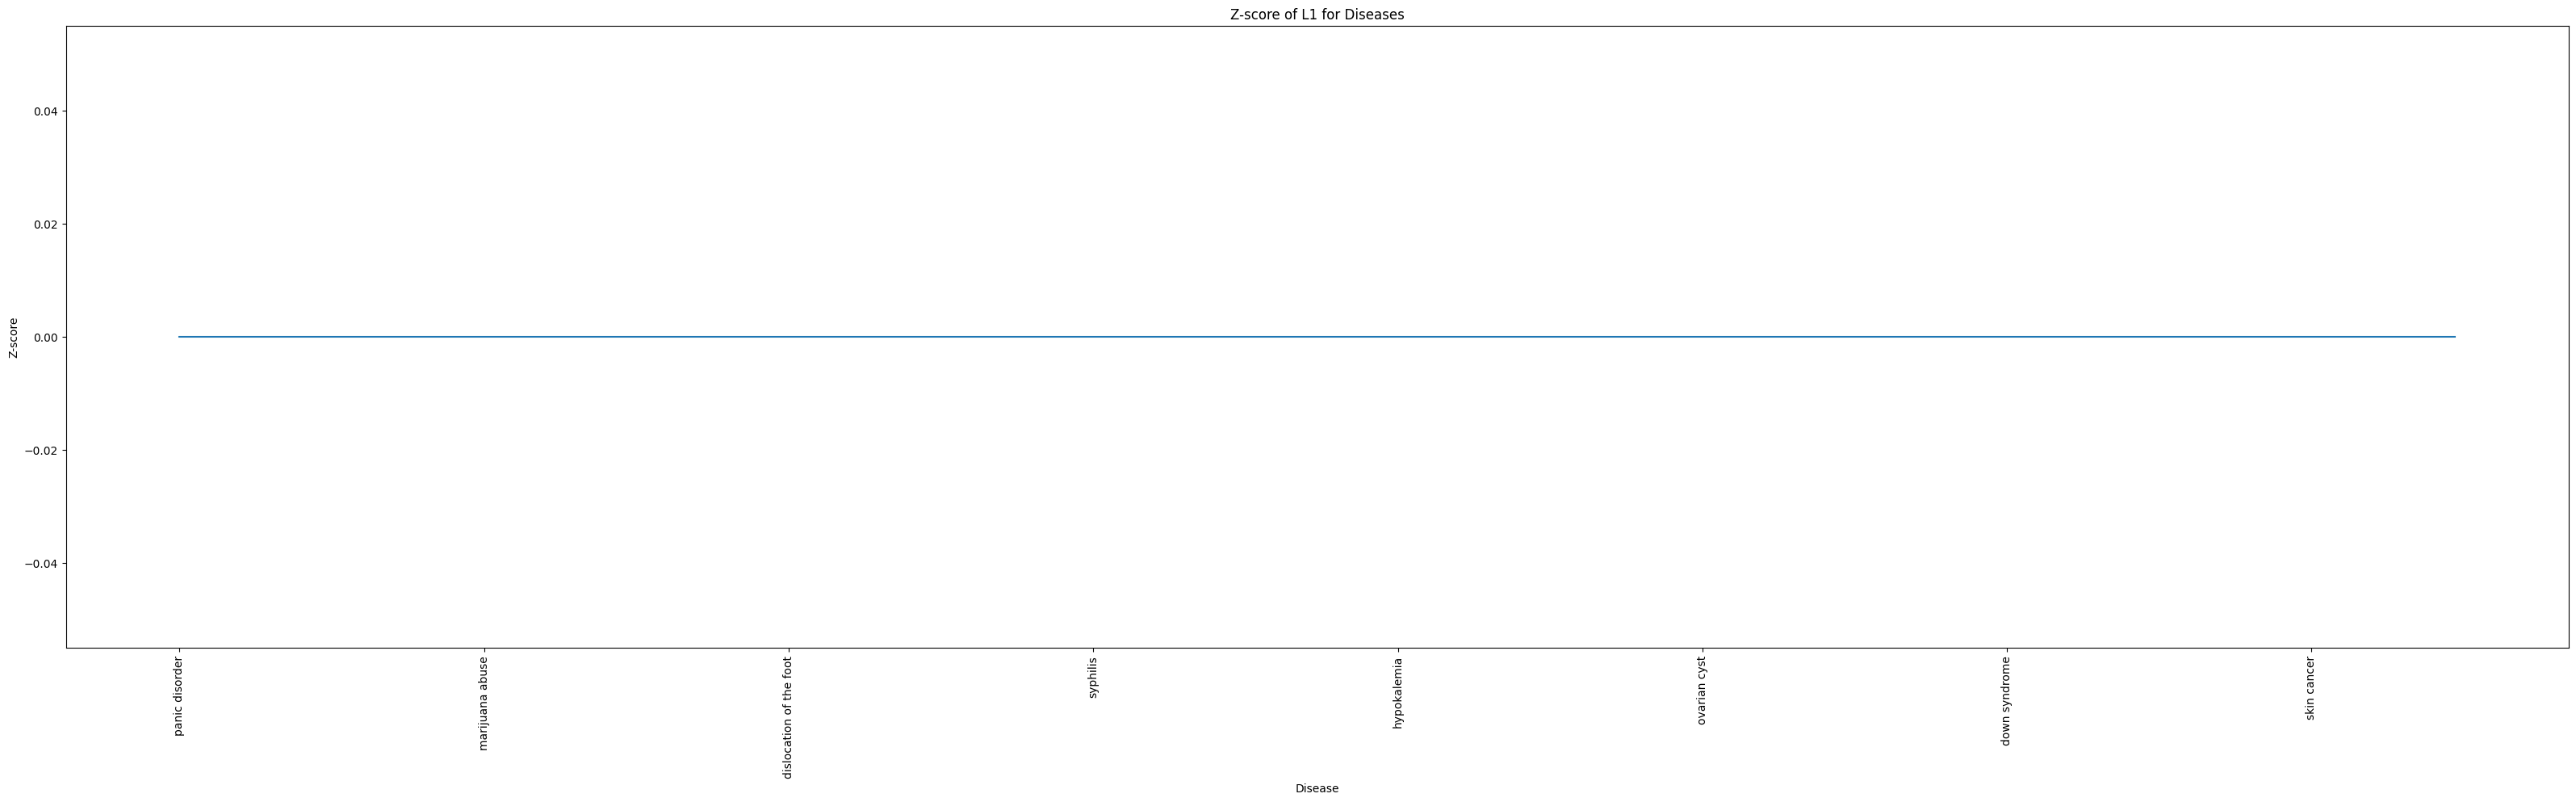

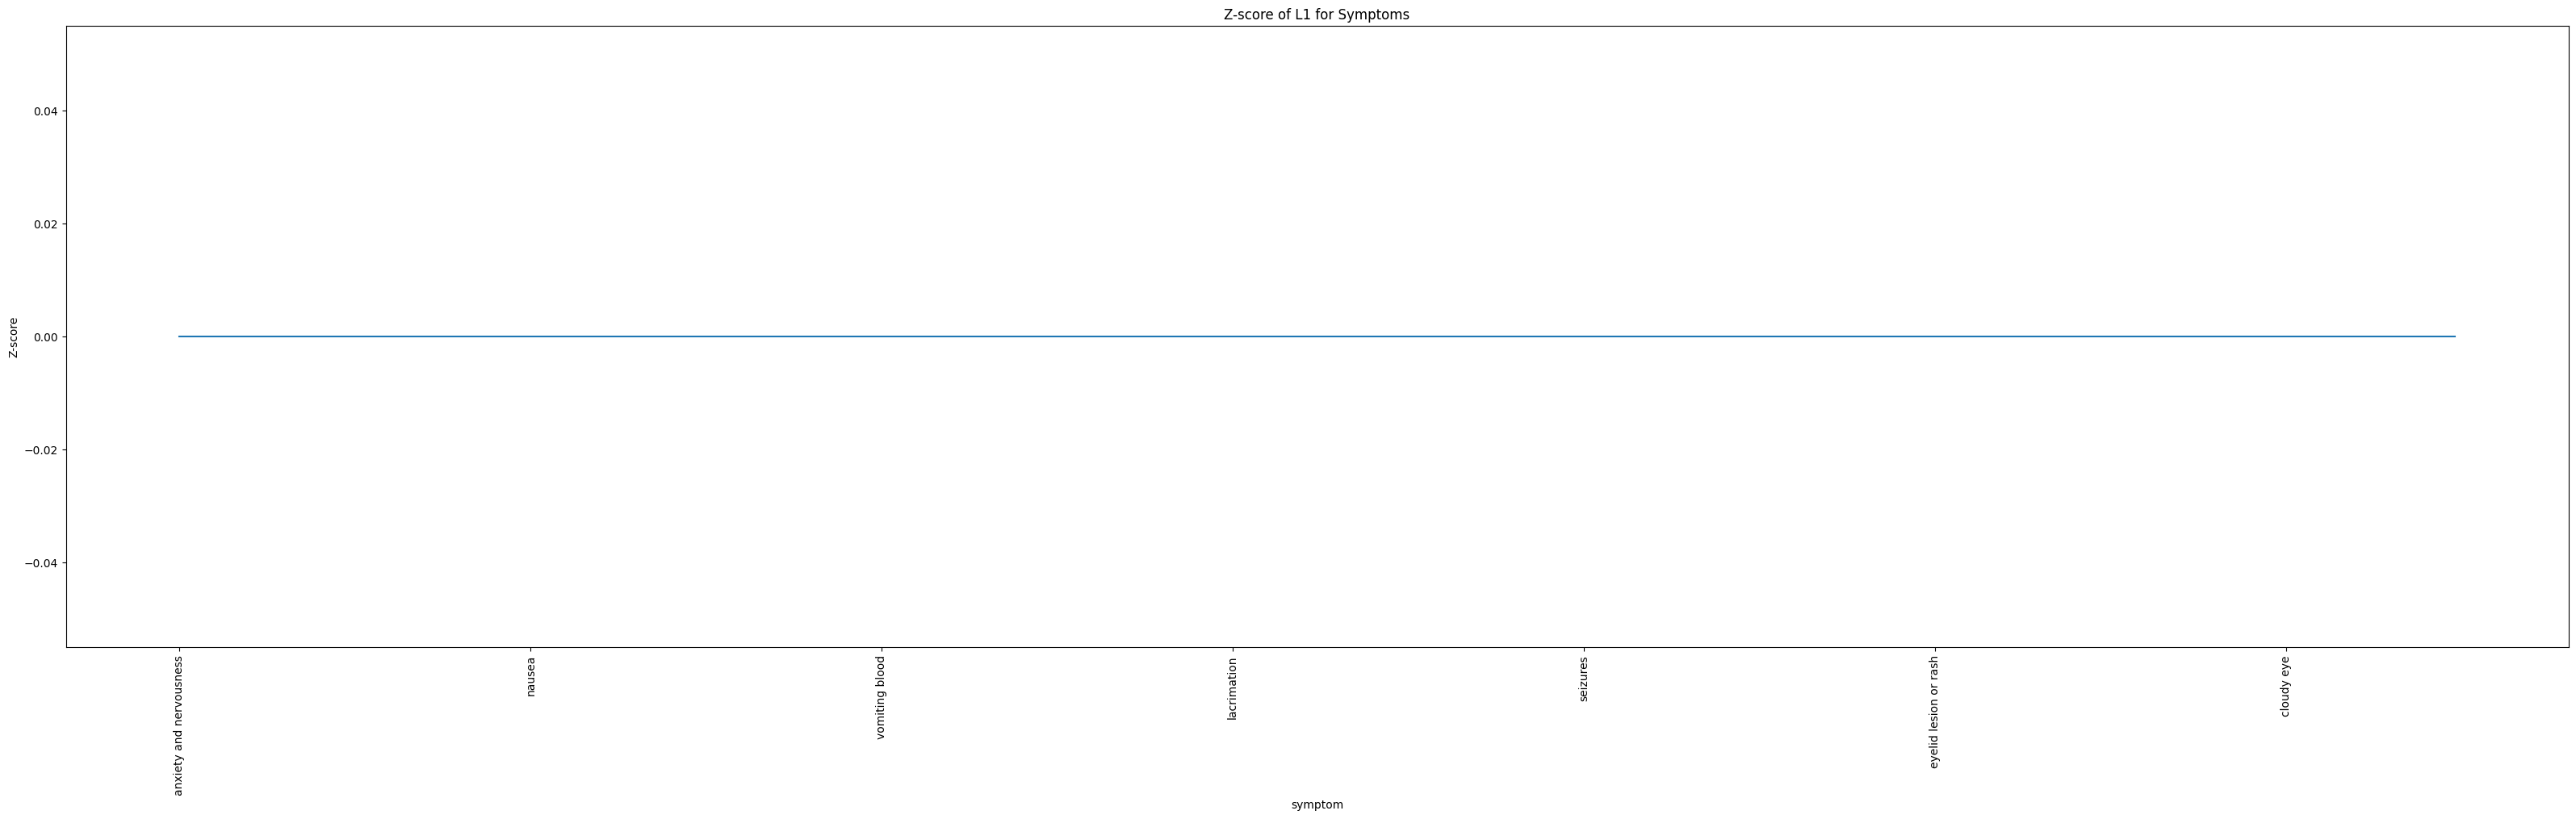

In [16]:
disease_df.plot.line(
    x="Disease",
    y="L1 Z-score",
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Diseases",
    color='#1f77b4'
)


symptoms_df.plot.line(
    x="symptom",
    y="L1 Z-score",
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L1 for Symptoms",
    color='#1f77b4'
)

### L2

<Axes: title={'center': 'Z-score of L2 for Symptoms'}, xlabel='symptom', ylabel='Z-score'>

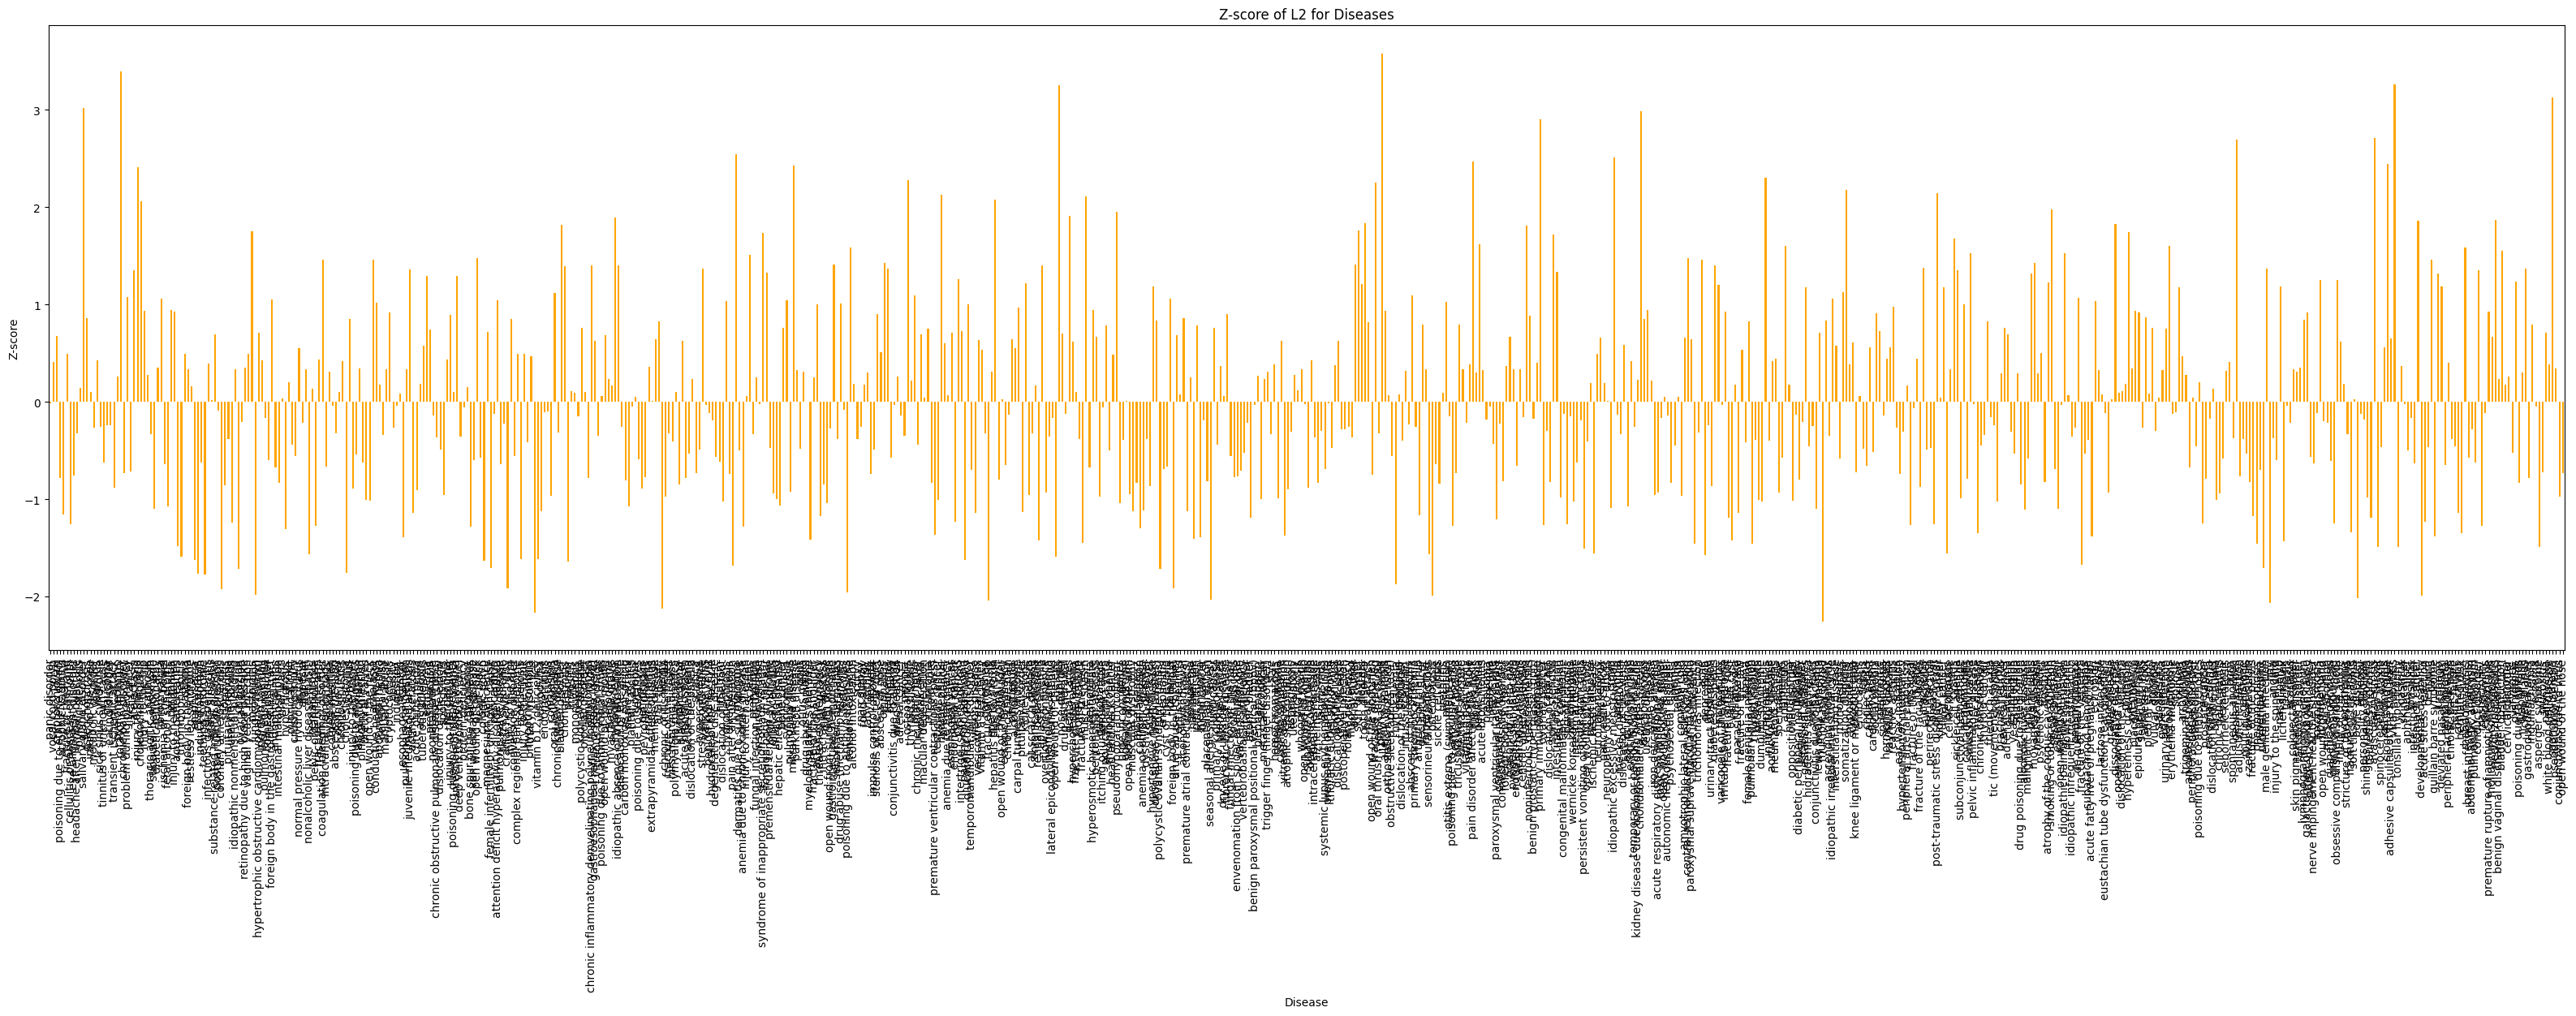

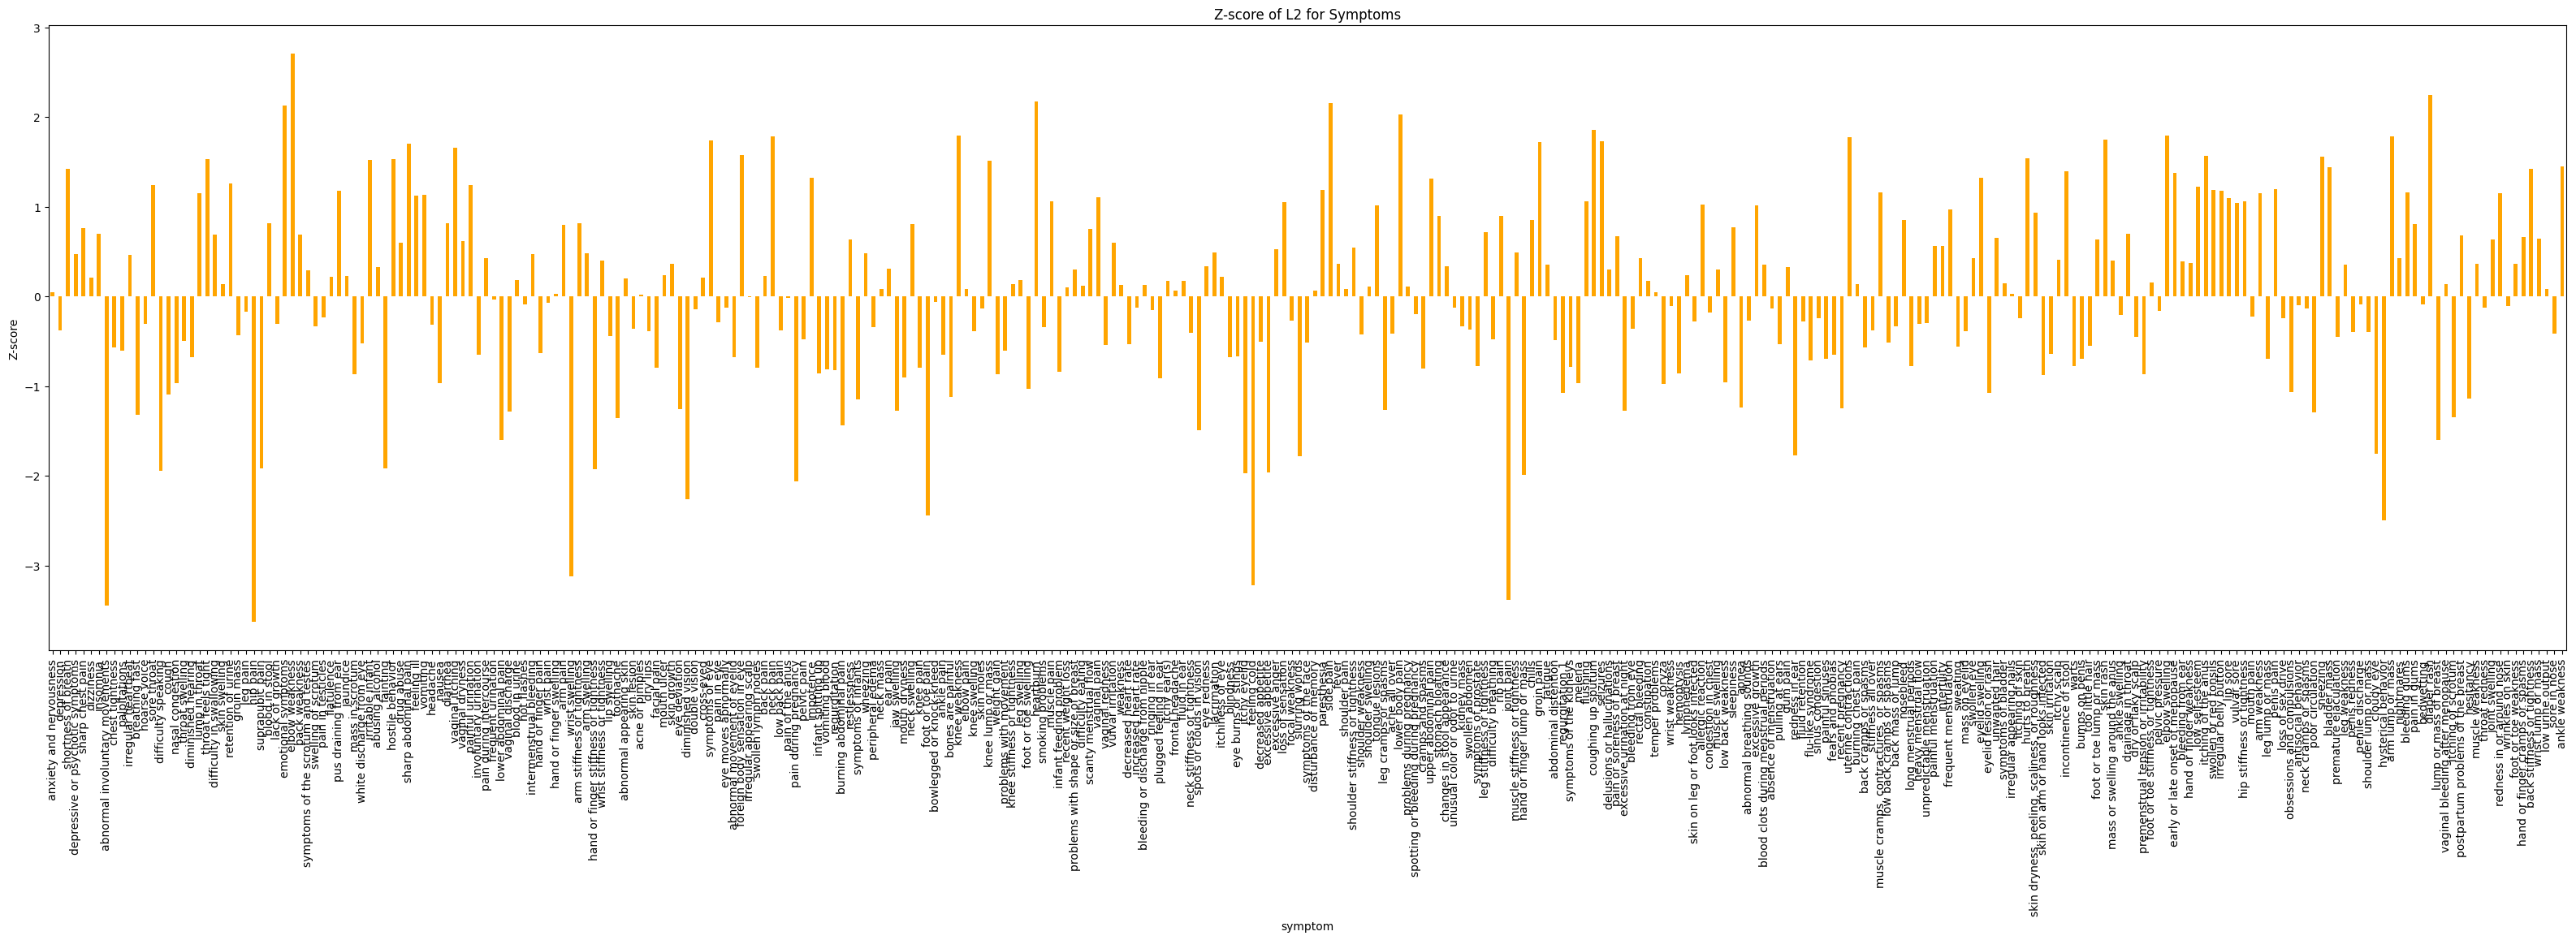

In [15]:
disease_df.plot.bar(
    x="Disease",
    y=["L2 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Diseases",
    color="orange",
)


symptoms_df.plot.bar(
    x="symptom",
    y=["L2 Z-score"],
    rot=90,
    figsize=(40, 10),
    legend=False,
    ylabel="Z-score",
    title="Z-score of L2 for Symptoms",
    color="orange",
)

## Plot PDF

### Level 1

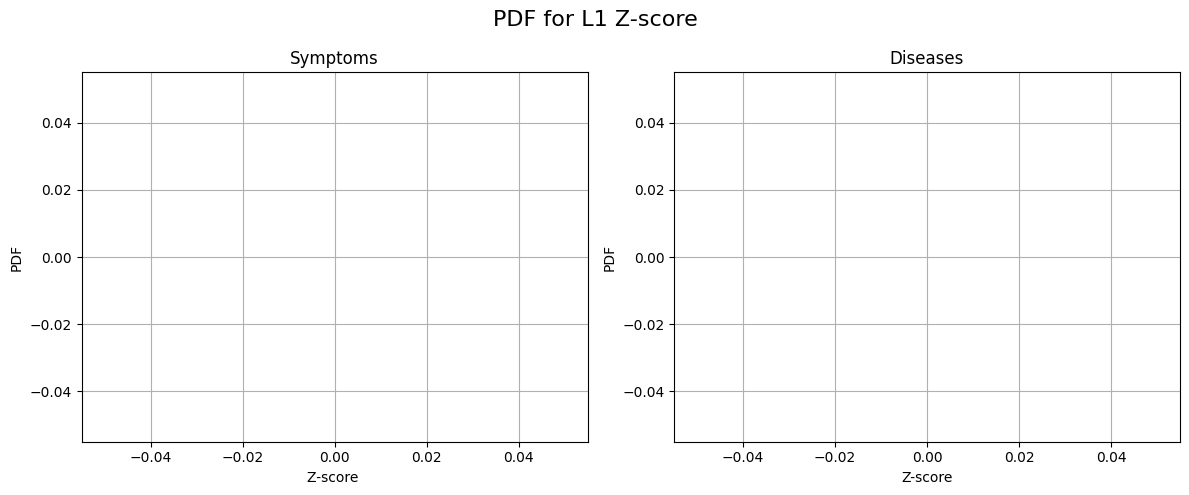

In [16]:
metric1_values = symptoms_df["L1 Z-score"]
metric2_values = disease_df["L1 Z-score"]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("PDF for L1 Z-score", fontsize=16)


# Plot the PDF for Metric 1
plt.title("PDF of L1 Z-scores ")
sns.kdeplot(metric1_values, fill=True, ax=axes[0], warn_singular=False, color='lightcoral')
axes[0].set_title("Symptoms")
axes[0].set_xlabel("Z-score ")
axes[0].set_ylabel("PDF")
axes[0].grid()

# Plot the PDF for Metric 2
sns.kdeplot(metric2_values, fill=True, ax=axes[1], warn_singular=False, color='#1f77b4')
axes[1].set_title("Diseases")
axes[1].set_xlabel("Z-score")
axes[1].set_ylabel("PDF")
axes[1].grid()
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### Level 2

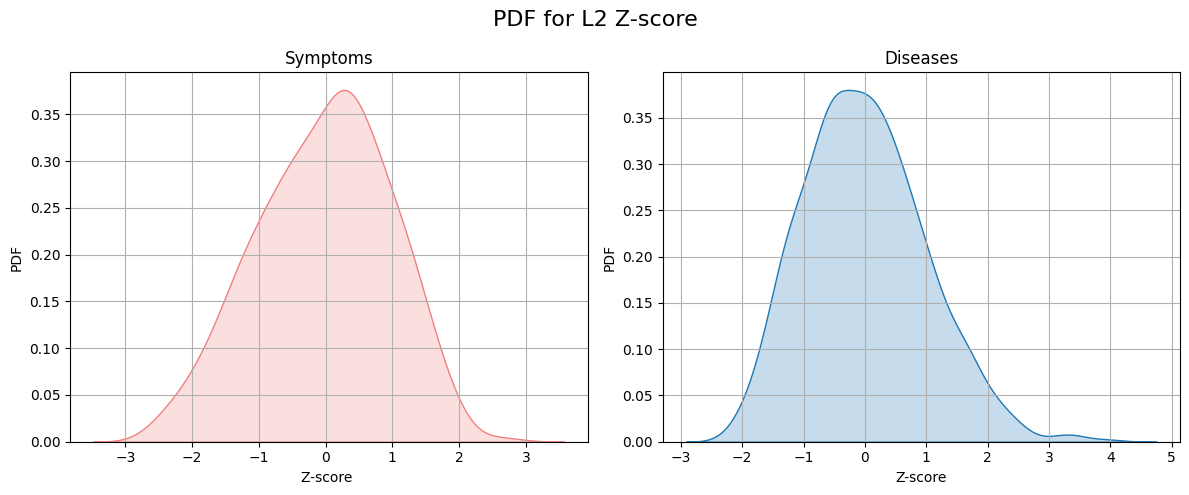

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'metric1' and 'metric2' are the columns you want to plot
metric1_values = symptoms_df["L2 Z-score"]
metric2_values = disease_df["L2 Z-score"]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("PDF for L2 Z-score", fontsize=16)

# Plot the PDF for Symptom
sns.kdeplot(metric1_values, fill=True, ax=axes[0], color="lightcoral")
axes[0].set_title("Symptoms")
axes[0].set_xlabel("Z-score ")
axes[0].set_ylabel("PDF")
axes[0].grid("on")

# Plot the PDF for Disease
sns.kdeplot(metric2_values, fill=True, ax=axes[1], color="#1f77b4")
axes[1].set_title("Diseases")
axes[1].set_xlabel("Z-score")
axes[1].set_ylabel("PDF")
axes[1].grid("on")
# Adjust layout and show the plot
plt.tight_layout()
plt.show()